### CUSTOMER CHURN PREDICTION

#### Business Overview

SyriaTel, a telecommunications company, is faced with the challenge of customer churn – the phenomenon where customers discontinue their services with the company. Churn can significantly impact the company's revenue and profitability, making it crucial for SyriaTel to identify and mitigate factors leading to customer attrition. The business objective is to build a classifier that predicts whether a customer is likely to "soon" stop doing business with SyriaTel, thereby enabling proactive retention strategies.

#### Business Understanding

Customer churn in the telecom industry can be influenced by various factors, including service quality, pricing, customer service, and competitive offerings. By leveraging data analytics and machine learning, SyriaTel aims to gain insights into patterns and indicators associated with customer churn. Understanding these patterns can empower the company to take preventive measures, such as targeted marketing campaigns, personalized offers, or improved customer service, to retain valuable customers.

#### Background


SyriaTel operates in a dynamic and competitive telecommunications market, where customer preferences and expectations continually evolve. The need to address customer churn is critical not only for maintaining revenue but also for sustaining a positive brand image. By adopting a data-driven approach, SyriaTel acknowledges the potential of machine learning in uncovering hidden patterns and predicting future customer behavior.

###### Dataset: https://www.kaggle.com/datasets/becksddf/churn-in-telecoms-dataset

#### Preliminaries

Import all the relevant libraries needed


In [52]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px

#Modelling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display, HTML
from sklearn.metrics import roc_curve, auc

from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, f1_score, precision_score

import warnings
warnings.filterwarnings('ignore')

In [53]:
#Improving the visualizations
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

Data Sourcing class that handles loading of data and checking its details

In [54]:

class DataSourcing:
    def __init__(self):
        pass
    
    def open_file(self, path):
        df = pd.read_csv(path)
        return df
    def dataframe_details(self,df):
        """
        Print details of the dataframe.
        Parameters:
        df (DataFrame): The dataframe to be analyzed.
        Returns:
        None
        """
        print(f"DATAFRAME SHAPE: {df.shape}\n\n")
        print(f"{df.info()}\n\n")
        print(f"DATAFRAME HEAD:\n {df.head()}\n\n")

        print(f"DATAFRAME KEY STATISTIC DESCRIPTION:\n {df.describe()}\n\n")      


Data Preprocessing Class that handles Cleaning and data preparation

In [55]:
class DataPreprocessing(DataSourcing):
    def __init__(self):
        super().__init__()
        """Data Preprocessing class that inherits from the data sourcing class.
        Contains functions to be used to check certain aspects in the data for cleaning.
        Checks for duplicates, nulls and outliers
        """

    def check_duplicates(self, data):
        duplicates = data[data.duplicated()]
        return duplicates

    def check_null_values(self, data):
        null_values = data.isnull().sum()
        return null_values
    
    def dropcolumns(self,data,columns):
        data= data.drop(columns,axis=1)
        return data
    
    def droprows(self, data, rows):
        data= data.drop(rows, axis=0)
        return data
    
    def combine_columns(self, data):    
        # Calculate total calls
        data["total_calls"] = data["total day calls"] + data["total night calls"] + data["total eve calls"] + data["total intl calls"]

        # Calculate total minutes
        data["total_minutes"] = data["total day minutes"] + data["total night minutes"] + data["total eve minutes"] + data["total intl minutes"]

        # Calculate total charges
        data["total_charges"] = data["total day charge"] + data["total night charge"] + data["total eve charge"] + data["total intl charge"]

        # Drop unnecessary columns
        data.drop(columns=["total day calls", "total night calls", "total eve calls", "total intl calls",
                           "total day minutes", "total night minutes", "total eve minutes", "total intl minutes",
                           "total day charge", "total night charge", "total eve charge", "total intl charge"],
                  inplace=True)
        print(data.columns)
        return data
    
    def check_column(self, data):
        print(data.columns)



In [56]:
class DataAnalysis(DataPreprocessing,DataSourcing):

    #category =df[['state','area code','international plan','voice mail plan']]
    def __init__(self,data=None):
        self.data = data

    #categorical columns vs churn- state, voice mail, international
    def plot_histogram(self,data,columns):
        for column in columns:
            title= f'{column.capitalize()} vs. Churn'
            fig= px.histogram(data, x=column, title=title, color='churn')

            #sns.countplot(data,x= column[-1] )

            fig.show()

    def box_plots(self, data):
        plt.figure(figsize=(14, 5))
        custom_pallete= sns.color_palette('Set3')
        sns.boxplot(data=data, x='churn', y='customer service calls', hue='area code')
        plt.legend(loc='upper right')
        
        plt.show()


    def univariate_analysis(self,data, numeric_cols):
        # Plot histograms and box plots for numeric columns
        for column in numeric_cols:
            plt.figure(figsize=(19, 6))

            # Plot histogram
            plt.subplot(1, 2, 1)
            sns.distplot(self.data[column], bins=30, kde=True)
            plt.title(f'Distributionplot for {column}')

            # Plot box plot
            plt.subplot(1, 2, 2)
            sns.boxplot(x=self.data[column])
            plt.title(f'Box Plot for {column}')
            plt.show()


    def plot_corr_heatmap(self, numeric_cols, figsize=(15, 12)):
        # Extract numeric columns from the DataFrame
        numeric_data = self.data[numeric_cols]

        # Calculate the correlation matrix
        corr_mat = numeric_data.corr()

        plt.figure(figsize=figsize)
        sns.heatmap(corr_mat, annot=True, cmap='Blues', square=True, fmt='.2f')

        plt.xticks(rotation=90)
        plt.yticks(rotation=0)
        plt.show()

    
    def label_encode_target(self,data,columns):
        le= LabelEncoder()
        
        for column in columns:
            data[column]= le.fit_transform(data[column])

        return data




##### Modelling Class

In [57]:
class Modelling(DataAnalysis,DataPreprocessing,DataSourcing):
    lr = LogisticRegression()
    dc = DecisionTreeClassifier()
    rf = RandomForestClassifier()
    knn = KNeighborsClassifier(n_neighbors=5)
    def __init__(self,data=None):
        self.data = data


    def split_data(self, data, target, test_size=0.2, random_state=42):
        X= data.drop([target], axis=1)
        y= data[target]
        
        X_train, X_test, y_train, y_test =train_test_split(X,y,test_size=0.2, random_state= 42)

        return X_train, X_test, y_train, y_test
    
    def apply_smote(self, X_train, y_train,sampling_strategy=0.75, k_neighbors=5, random_state= None):
        smote = SMOTE(sampling_strategy=sampling_strategy, k_neighbors=k_neighbors, random_state=random_state)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

        return X_train_resampled, y_train_resampled
    
    
    def modelplotting_evaluation(self, X_train, X_test, y_train, y_test):
        Results = {'Model': [], 'Accuracy': [], 'Recall': [], 'Precision': [], 'F1': []}

        lr = LogisticRegression()
        dc = DecisionTreeClassifier()
        rf = RandomForestClassifier()
        knn = KNeighborsClassifier(n_neighbors=5)

        # fitting and prediction
        model_list = [lr, dc, rf, knn]

        for models in model_list:
            models.fit(X_train, y_train)

            y_pred = models.predict(X_test)

            print('Model :', models)
            print('--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')

            print('confusion matrix :', confusion_matrix(y_test, y_pred))
            print('classification_report:', classification_report(y_test, y_pred))
            print('accuracy_score:', accuracy_score(y_test, y_pred))
            print('precision_score:', precision_score(y_test, y_pred))
            print('recall_score:', recall_score(y_test, y_pred))
            print('f1 :', f1_score(y_test, y_pred))
            print()

            R = {'Model': str(models),
                 'Accuracy': accuracy_score(y_test, y_pred),
                 'Recall': recall_score(y_test, y_pred),
                 'Precision': precision_score(y_test, y_pred),
                 'F1': f1_score(y_test, y_pred)
                }

            Results['Model'].append(R['Model'])
            Results['Accuracy'].append(R['Accuracy'])
            Results['Recall'].append(R['Recall'])
            Results['Precision'].append(R['Precision'])
            Results['F1'].append(R['F1'])

        return pd.DataFrame(Results)
    
    def plot_roc_curves(self,models, X_test, y_test):
    
        plt.figure(figsize=(10, 8))

        for model in models:
        # Fit the model (if not already fitted)
            if hasattr(model, 'predict_proba'):
                model.fit(X_train, y_train)

            # Predict probabilities for positive class
            y_prob = model.predict_proba(X_test)[:, 1]

            # Compute ROC curve and AUC
            fpr, tpr, thresholds = roc_curve(y_test, y_prob)
            roc_auc = auc(fpr, tpr)

            # Plot ROC curve
            plt.plot(fpr, tpr, label=f'{str(model).split("(")[0]} (AUC = {roc_auc:.2f})')

        # Plot the diagonal line representing random guessing
        plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')

        # Set plot labels and title
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves for Churn Prediction Models')
        plt.legend(loc='lower right')

        plt.show()

    def hyperparameter_tuning(self, X_train, X_test, y_train, y_test):
        model=RandomForestClassifier()
        param_grid={
            'n_estimators': [100,200,300],
            'max_depth': [None,5,10],
            'min_samples_split': [2,5,10],
            'min_samples_leaf': [1,2,4]
        }
        grid_search=GridSearchCV(model,param_grid,cv=5)
        grid_search.fit(X_train, y_train)
        best_model=grid_search.best_estimator_
        #best_params = grid_search.best_params_
        y_pred=best_model.predict(X_test)
        score=best_model.score(X_test,y_test)
        return score
    

### 1. Data Understanding

The features help establish if there is a pattern associated with customers who churn from Syria Telcom or not

In [58]:
load= DataSourcing()
path= "/home/marie/Documents/MORINGA/PHASE 3/PROJECT/Datasets/Customer-Churn-Syria-Tel-/bigml_59c28831336c6604c800002a.csv"
df=load.open_file(path)


In [59]:
load.dataframe_details(df)

DATAFRAME SHAPE: (3333, 21)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total nigh

### Data Preprocessing(Cleaning)

Removing irrelevant columns, missing value and duplicate rows

In [60]:
clean= DataPreprocessing()
clean.check_duplicates(df)


,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn


In [61]:
clean.check_null_values(df)

state                     0
account length            0
area code                 0
phone number              0
international plan        0
voice mail plan           0
number vmail messages     0
total day minutes         0
total day calls           0
total day charge          0
total eve minutes         0
total eve calls           0
total eve charge          0
total night minutes       0
total night calls         0
total night charge        0
total intl minutes        0
total intl calls          0
total intl charge         0
customer service calls    0
churn                     0
dtype: int64

In [62]:
df=clean.dropcolumns(df,['phone number'])


In [63]:
clean.check_column(df)

Index(['state', 'account length', 'area code', 'international plan',
       'voice mail plan', 'number vmail messages', 'total day minutes',
       'total day calls', 'total day charge', 'total eve minutes',
       'total eve calls', 'total eve charge', 'total night minutes',
       'total night calls', 'total night charge', 'total intl minutes',
       'total intl calls', 'total intl charge', 'customer service calls',
       'churn'],
      dtype='object')


In [64]:
#df1= df.copy()

In [65]:
df1=clean.combine_columns(df)

Index(['state', 'account length', 'area code', 'international plan',
       'voice mail plan', 'number vmail messages', 'customer service calls',
       'churn', 'total_calls', 'total_minutes', 'total_charges'],
      dtype='object')


In [66]:
df1

,state,account length,area code,international plan,voice mail plan,number vmail messages,customer service calls,churn,total_calls,total_minutes,total_charges
0,KS,128,415,no,yes,25,1,False,303,717.2,75.56
1,OH,107,415,no,yes,26,1,False,332,625.2,59.24
2,NJ,137,415,no,no,0,0,False,333,539.4,62.29
3,OH,84,408,yes,no,0,2,False,255,564.8,66.80
4,OK,75,415,yes,no,0,3,False,359,512.0,52.09
...,...,...,...,...,...,...,...,...,...,...,...
3328,AZ,192,415,no,yes,36,2,False,292,660.7,60.10
3329,WV,68,415,no,no,0,3,False,239,585.4,63.53
3330,RI,28,510,no,no,0,2,False,264,675.6,67.74
3331,CT,184,510,yes,no,0,2,False,336,517.6,57.53


### Exploratory Data Analysis

In [67]:
#df1=load.open_file("/home/marie/Documents/MORINGA/PHASE 3/PROJECT/Datasets/dataset/archive (1)/bigml_59c28831336c6604c800002a.csv")
eda= DataAnalysis(data= df1)

columns_c= ['state', 'voice mail plan', 'international plan','churn']
eda.plot_histogram(df, columns_c)

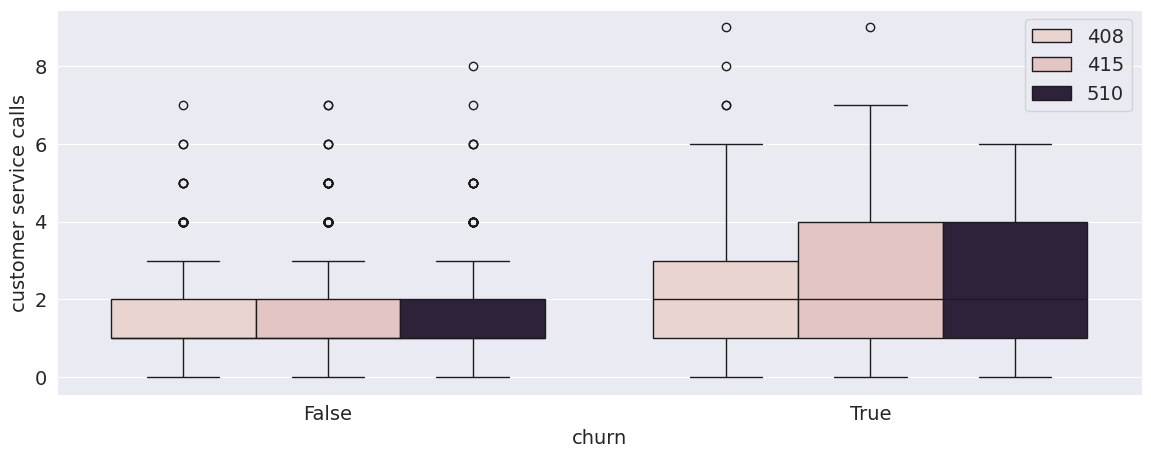

In [68]:
eda= DataAnalysis(data= df1)
eda.box_plots(df1)

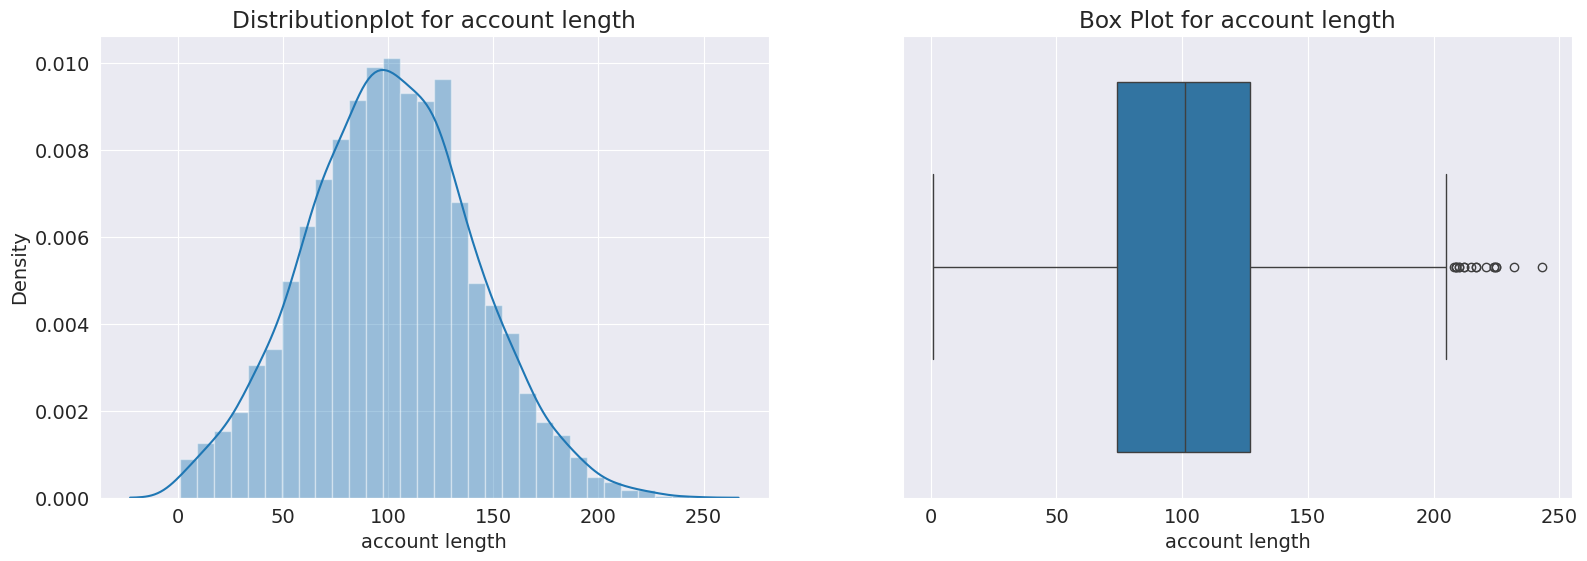

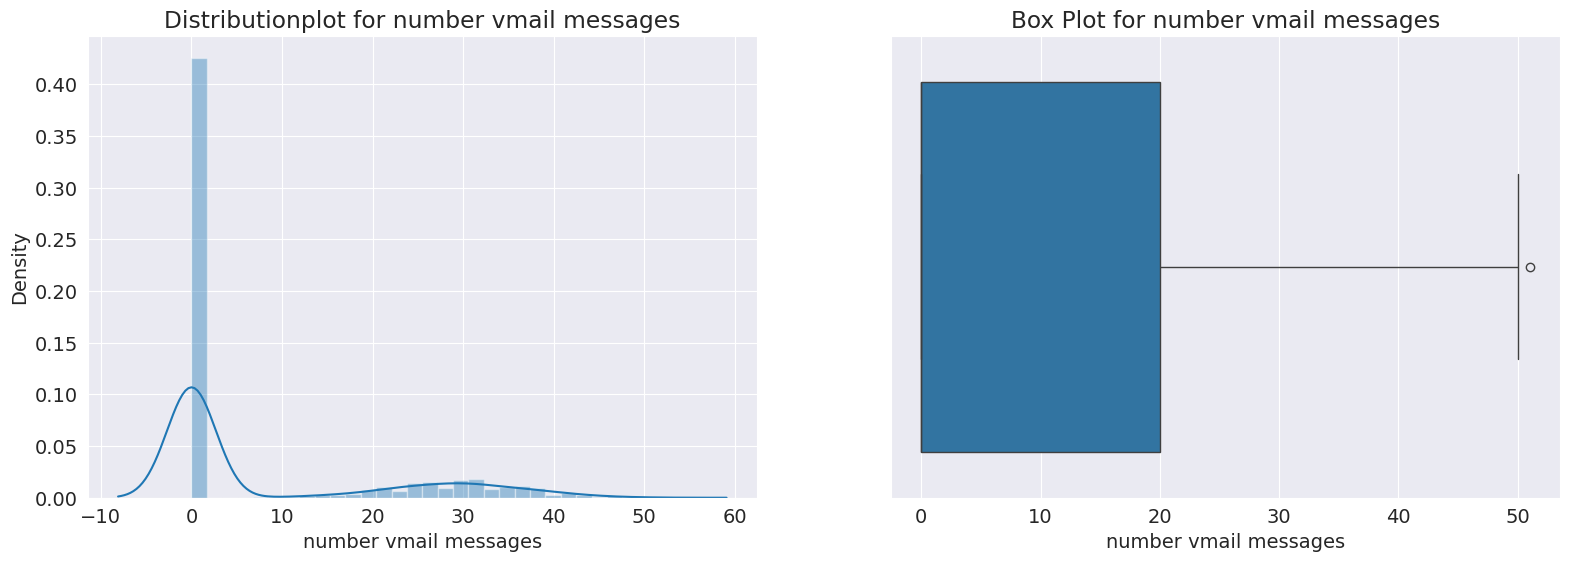

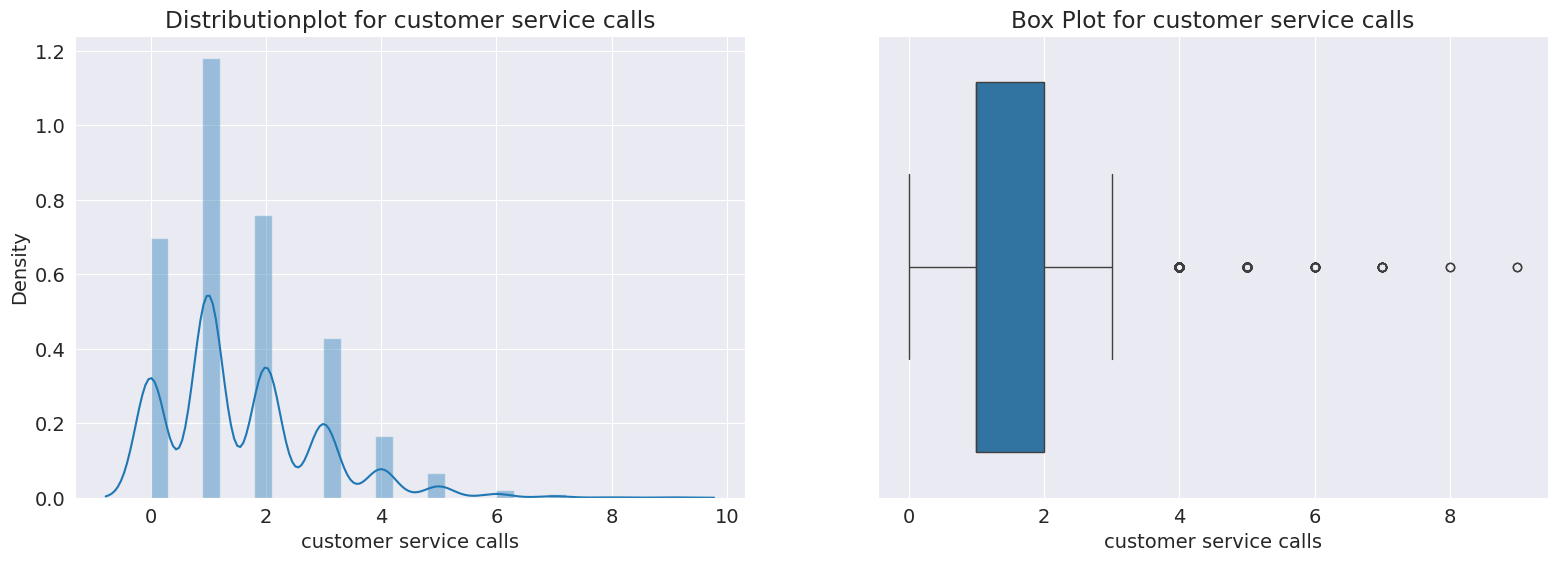

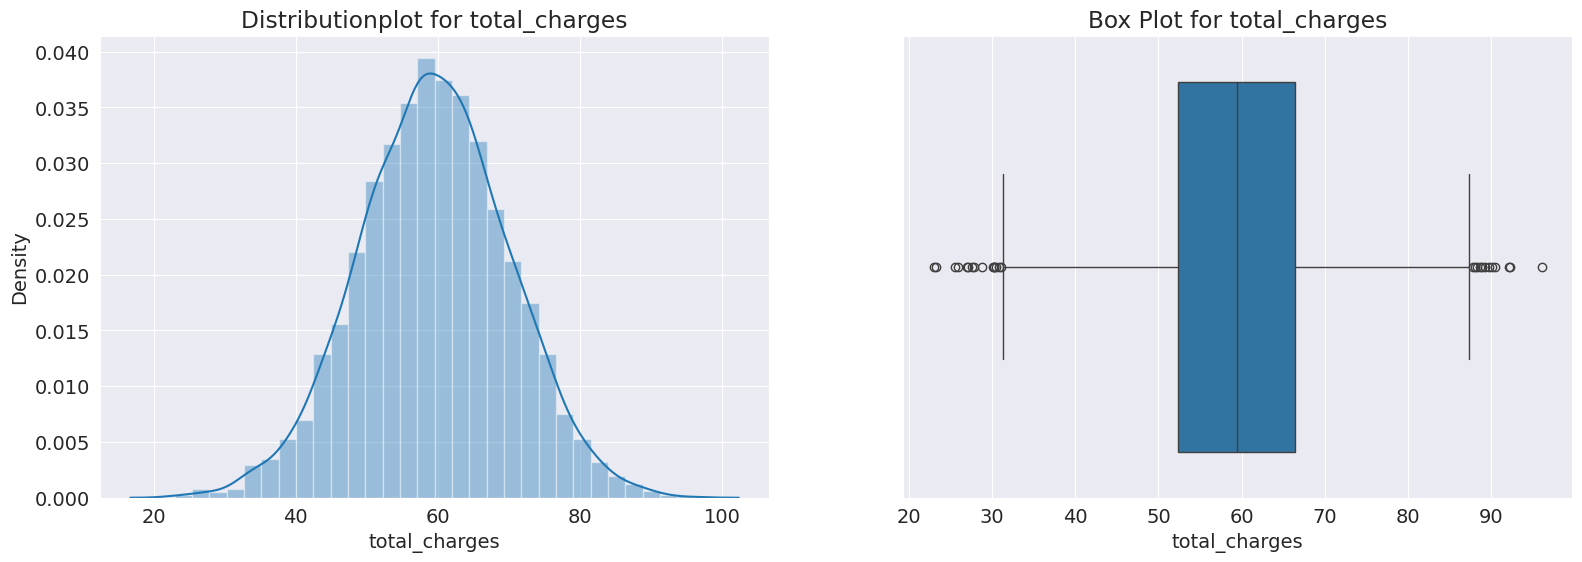

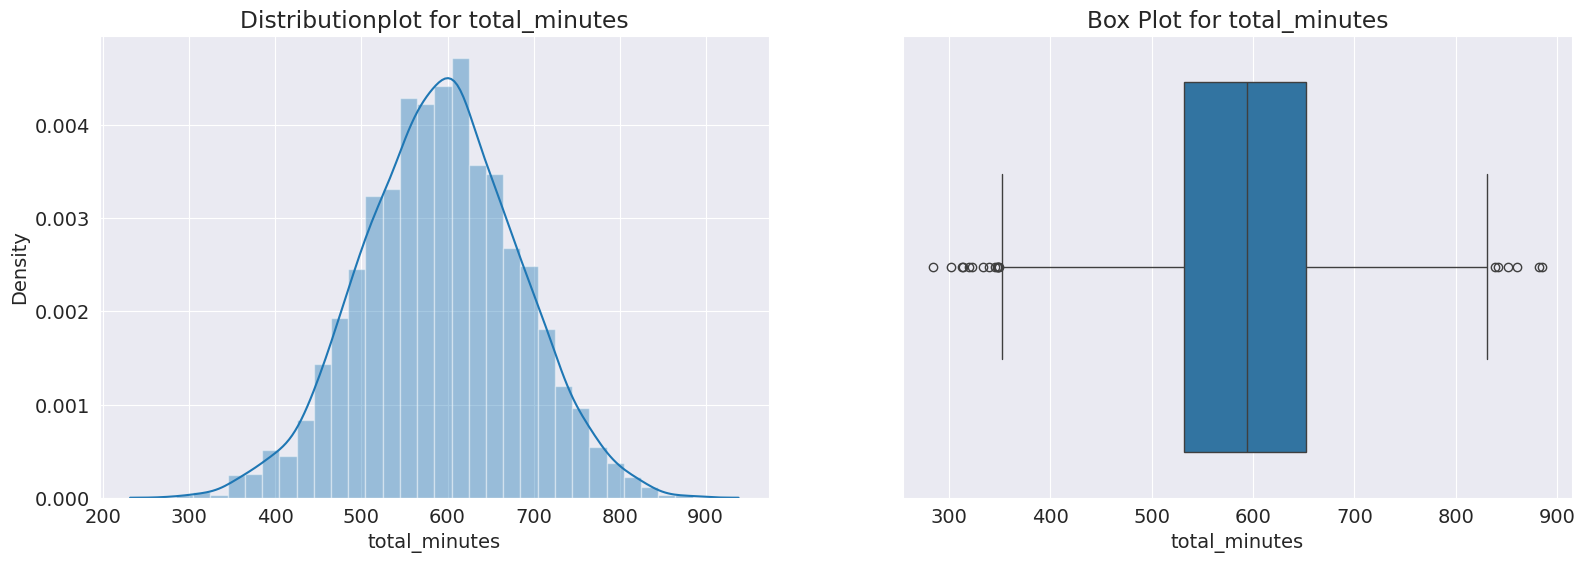

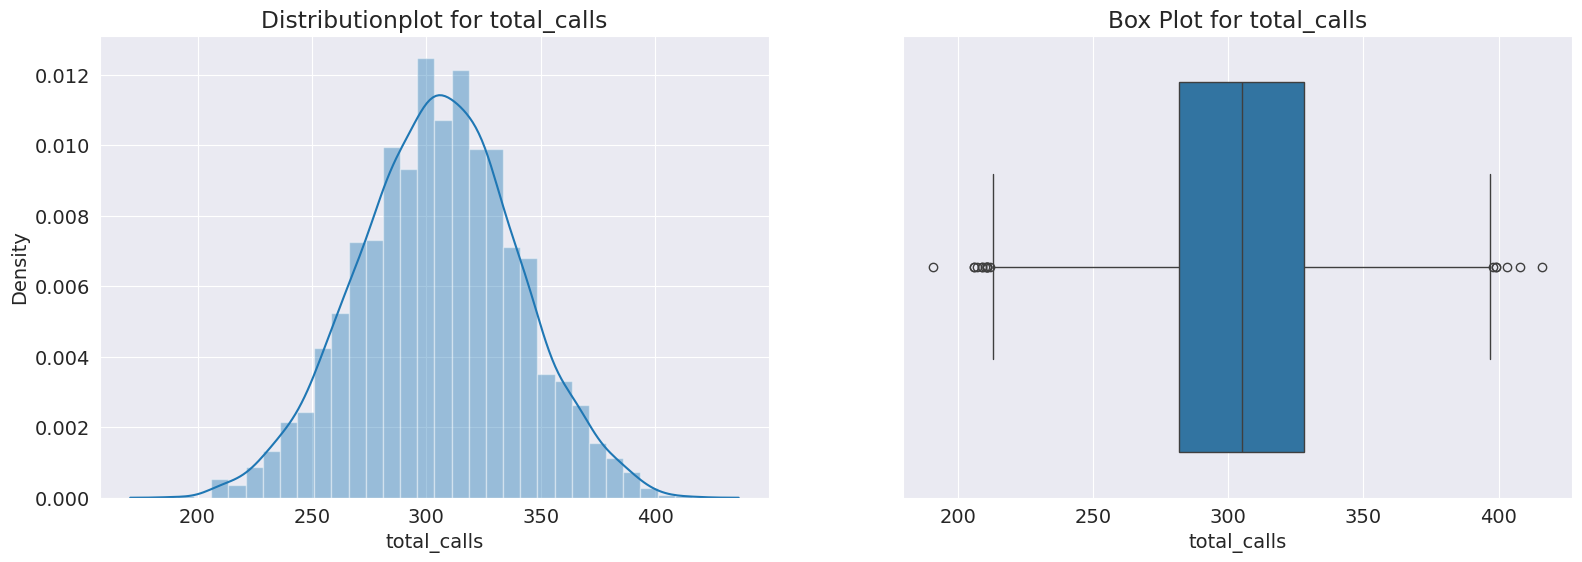

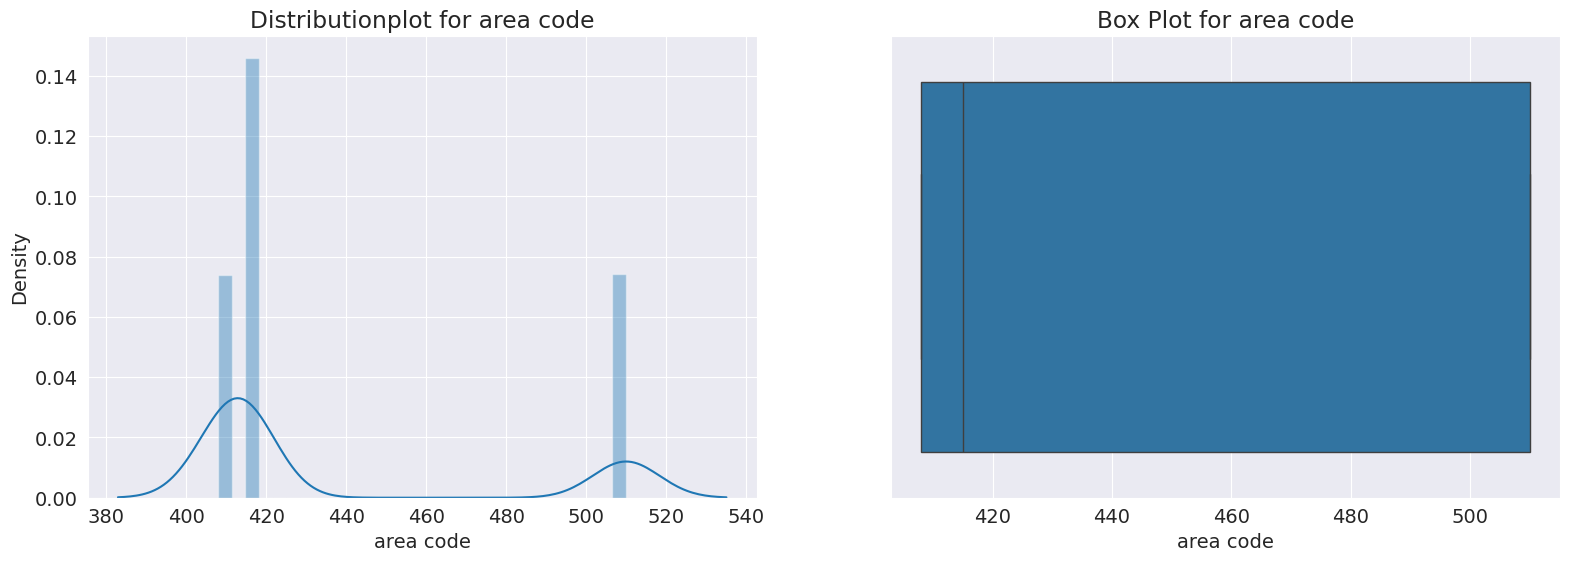

In [69]:
eda= DataAnalysis(data=df1)

numeric= df1[['account length','number vmail messages','customer service calls', 'total_charges','total_minutes','total_calls','area code']]
eda.univariate_analysis(df1, numeric)

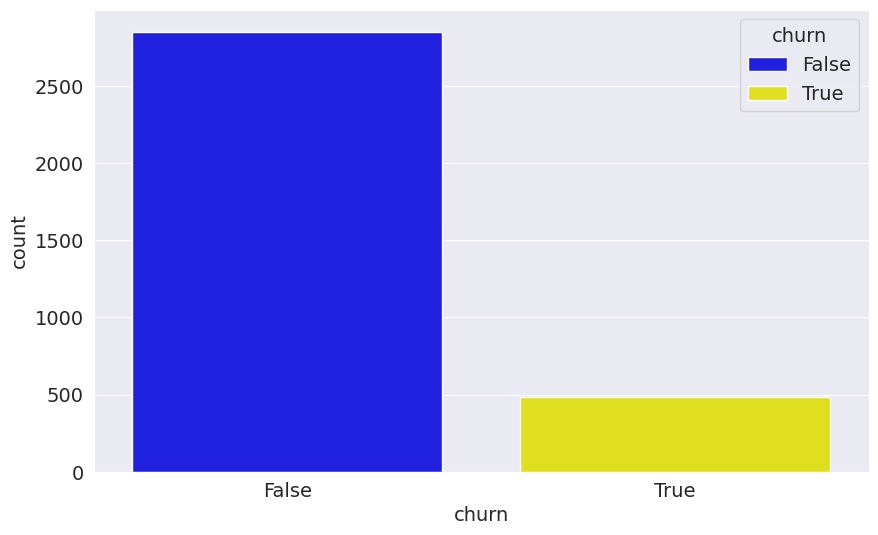

In [70]:
sns.countplot(data=df1, x='churn',hue= 'churn',palette={True: 'yellow', False:'blue'});

In [71]:
df1[['account length','number vmail messages','customer service calls', 'total_charges','total_minutes','total_calls','area code']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   account length          3333 non-null   int64  
 1   number vmail messages   3333 non-null   int64  
 2   customer service calls  3333 non-null   int64  
 3   total_charges           3333 non-null   float64
 4   total_minutes           3333 non-null   float64
 5   total_calls             3333 non-null   int64  
 6   area code               3333 non-null   int64  
dtypes: float64(2), int64(5)
memory usage: 182.4 KB


In [72]:
df1[['account length','number vmail messages','customer service calls', 'total_charges','total_minutes','total_calls','area code']].dtypes

account length              int64
number vmail messages       int64
customer service calls      int64
total_charges             float64
total_minutes             float64
total_calls                 int64
area code                   int64
dtype: object

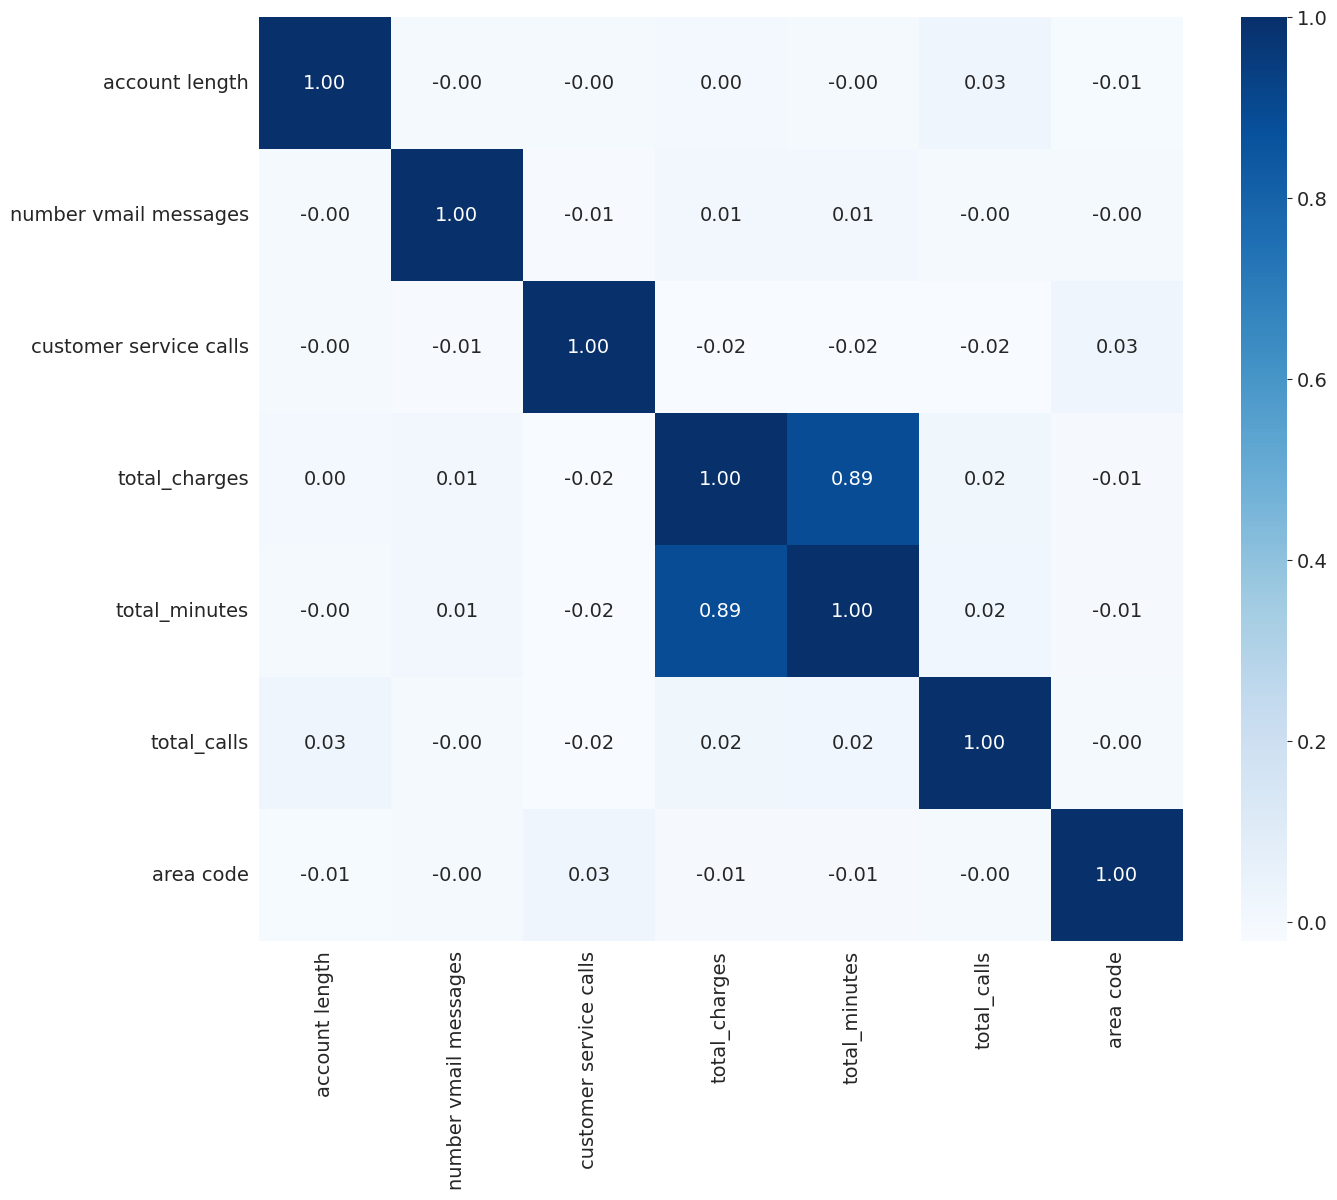

In [73]:
eda= DataAnalysis(data=df1)

numeric_cols= ['account length','number vmail messages','customer service calls', 'total_charges','total_minutes','total_calls', 'area code']
eda.plot_corr_heatmap(numeric_cols)

Dropping 1 of 2 columns that have high correlation which helps reduce the effect of multicollinearity

In [74]:

clean.dropcolumns(df1,['total_minutes'])

,state,account length,area code,international plan,voice mail plan,number vmail messages,customer service calls,churn,total_calls,total_charges
0,KS,128,415,no,yes,25,1,False,303,75.56
1,OH,107,415,no,yes,26,1,False,332,59.24
2,NJ,137,415,no,no,0,0,False,333,62.29
3,OH,84,408,yes,no,0,2,False,255,66.80
4,OK,75,415,yes,no,0,3,False,359,52.09
...,...,...,...,...,...,...,...,...,...,...
3328,AZ,192,415,no,yes,36,2,False,292,60.10
3329,WV,68,415,no,no,0,3,False,239,63.53
3330,RI,28,510,no,no,0,2,False,264,67.74
3331,CT,184,510,yes,no,0,2,False,336,57.53


In [75]:
eda= DataAnalysis(data= df1)
category =df1[['state','area code','international plan','voice mail plan','churn']]
encoded_target= eda.label_encode_target(df1,category)


In [76]:
df1.head()

,state,account length,area code,international plan,voice mail plan,number vmail messages,customer service calls,churn,total_calls,total_minutes,total_charges
0,16,128,1,0,1,25,1,0,303,717.2,75.56
1,35,107,1,0,1,26,1,0,332,625.2,59.24
2,31,137,1,0,0,0,0,0,333,539.4,62.29
3,35,84,0,1,0,0,2,0,255,564.8,66.80
4,36,75,1,1,0,0,3,0,359,512.0,52.09


### Modelling

Creating object of the modeeling class

In [77]:
model= Modelling()

Splitting the data

In [78]:
X= df1.drop(['churn'],axis =1)
y= df1['churn']
X_train, X_test, y_train, y_test= model.split_data(df1,'churn')

In [79]:
X_train.shape

(2666, 10)

In [80]:
y_train.shape

(2666,)

SMOTE

### Applying SMOTE Technique to Resolve Unbalanced 'churn' Feature
* Synthetic Minority Oversampling Technique ("SMOTE") is an oversampling technique where synthetic samples are generated for the minority class. This algorithm helps to overcome the overfitting problem posed by random oversampling. It focuses on the feature space to generate new instances with the help of interpolation between the positive instances that lie together.
* The technique aims to balance class distribution by randomly increasing minority class examples by replicating them.

It's generally recommended to apply SMOTE (Synthetic Minority Over-sampling Technique) after splitting your data into training and testing sets. The reason for this is to ensure that synthetic samples created by SMOTE are not included in the test set, which could lead to data leakage and overestimation of the model's performance.

In [81]:
X_train_resampled, y_train_resampled = model.apply_smote(X_train, y_train, sampling_strategy=0.75, k_neighbors=5, random_state=123)

In [82]:
X_train_resampled.shape

(3997, 10)

In [83]:
y_train_resampled.shape

(3997,)

In [84]:
#X_test.shape

### Model Plotting and evaluation

Key Points:

*Precision: The percentage of correctly predicted positive observations out of the total predicted positives. A high precision indicates low false positives.

*Recall: The percentage of actual positive observations correctly predicted out of the total actual positives. High recall indicates low false negatives.

*F1-Score: The weighted average of precision and recall. It is a balance between precision and recall.

*Accuracy: The overall accuracy of the model in predicting both positive and negative instances.

In [85]:
from IPython.display import display, HTML

In [86]:
evaluation_results= model.modelplotting_evaluation(X_train_resampled,X_test,y_train_resampled,y_test)

Model : LogisticRegression()
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
confusion matrix : [[448 118]
 [ 39  62]]
classification_report:               precision    recall  f1-score   support

           0       0.92      0.79      0.85       566
           1       0.34      0.61      0.44       101

    accuracy                           0.76       667
   macro avg       0.63      0.70      0.65       667
weighted avg       0.83      0.76      0.79       667

accuracy_score: 0.7646176911544228
precision_score: 0.34444444444444444
recall_score: 0.6138613861386139
f1 : 0.4412811387900356

Model : DecisionTreeClassifier()
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
confusion matrix : [[489  77]
 [ 21  80]]
classification_repor

The choice of the best model depends on your specific goals. If you prioritize precision, recall, or a balance of both, you might choose different models.

Random Forest appears to have a good balance of precision and recall, along with high accuracy.

Decision Tree has high recall but lower precision compared to Random Forest.

Logistic Regression and KNN have lower precision and recall compared to the other models.

#### MODEL COMPARISON

ROC Curve

The roc_curve function computes the Receiver Operating Characteristic (ROC) curve by varying the decision threshold.
The auc function calculates the Area Under the Curve (AUC) for the ROC curve.
The ROC curves for each model are then plotted on the same graph, with the AUC displayed in the legend.

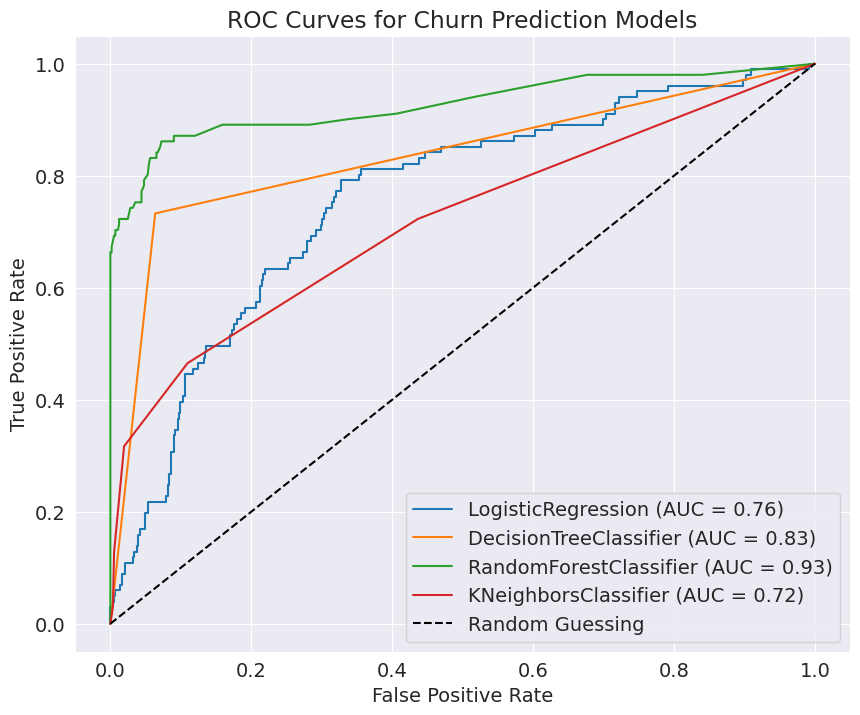

In [87]:
models= [model.lr, model.dc, model.rf, model.knn]
model.plot_roc_curves(models,X_test,y_test)

* The ROC curve illustrates the true positive rate against the false positive rate of our classifier.
* The best performing models will have a curve that hugs the upper left of the graph, which is the the random forest classifier in this case.

Random forest classifier is the best performing model with an AUC of 0.92



#### Hyperparameter tuning

In [88]:
model.hyperparameter_tuning(X_train_resampled,X_test,y_train_resampled, y_test)

0.9490254872563718


A 94% accuracy score after hyperparameter tuning is a positive outcome! It indicates that your model, a Random Forest Classifier in this case, is performing well on the test set.

#### Conclusions


Improving customer service interactions directly impacts satisfaction, reducing churn rates.

Customized Plans: Align pricing structures with actual usage to prevent dissatisfaction from high charges, thus reducing the likelihood of churn.

Enhance Service Quality: Address regional disparities in service quality to mitigate churn, considering varying satisfaction levels across different areas.

Promote Engagement: Encourage value-added services like voicemail plans, enhancing customer engagement and potentially reducing churn rates.

Continuous Monitoring: Regularly adapt strategies based on evolving customer needs, ensuring prompt adjustments aligned with customer preferences.

#### Recommendations

Addressing Imbalanced Classes: Due to potential class imbalance, especially in class 1, explore techniques such as oversampling, undersampling, or alternative evaluation metrics tailored for imbalanced datasets.

Hyperparameter Refinement: Enhance model performance through further hyperparameter tuning by adjusting the hyperparameter grid and exploring additional values.

Feature Importance Analysis: For decision tree-based models (Decision Tree, Random Forest), assess feature importance to identify the most influential features in predictions.

Cross-Validation Implementation: Increase robustness in performance estimation by incorporating cross-validation.